In [1]:
import time
import argparse
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Configuration
class Cfg:
    matchings = ['assignments_max_4_5.json', 'assignments_q_0.75_4_5.json']
    root_dir = './data/'

def hr(): return display(HTML('<hr>'))

In [2]:
def load_matchings_file(matchings_path):
    with open(matchings_path, 'r') as file:
        matchings = json.load(file)
    return matchings

def to_matchings_df(matchings):
    """Returns a dataframe with schema {'paper_id': 'str', 'scores': List[float], 'reviewers': List[str]}"""
    records = []
    for paper_id in matchings:
        vals = matchings[paper_id]
        scores = [v['aggregate_score'] for v in vals]
        reviewers = [v['user'] for v in vals]
        records.append({'paper_id': paper_id, 'scores': scores, 'reviewers': reviewers})
    return pd.DataFrame(records)

def to_load_df(matchings):
    """Returns a dataframe with schema {'reviewer_id': 'str', 'paper_ids': List[str], 'scores': List[str]}."""
    # reviewer_id -> [(paper_id, score), ...]
    reviewer_to_papers = {}
    for paper_id in matchings:
        for match in matchings[paper_id]:
            reviewer = match['user']
            score = match['aggregate_score']
            val = reviewer_to_papers.get(reviewer, [])
            val.append((paper_id, score))
            reviewer_to_papers[reviewer] = val
    df = pd.DataFrame({'reviewer_id': list(reviewer_to_papers.keys()),
                       'paper_info': list(reviewer_to_papers.values())})
    return df

In [3]:
# paper_id: [{'aggregate_score': float, 'user': str}, ...]
all_matchings = {fname: {'matchings': load_matchings_file(os.path.join(Cfg.root_dir, fname))} for fname in Cfg.matchings}

# General Score Statistics

- Mean score per paper and its standard deviation.
- Lowest 5% quantile score

Matchings: assignments_max_4_5.json


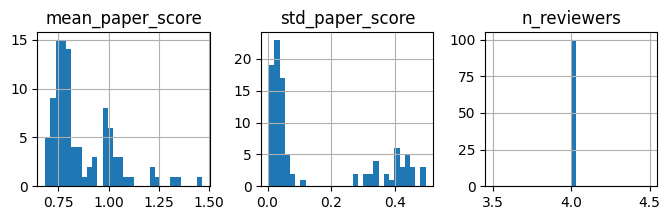

Matchings: assignments_q_0.75_4_5.json


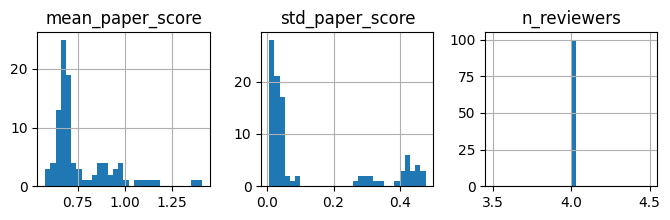

In [4]:
def plot_score_distr(df):   
    df['mean_paper_score'] = df['scores'].apply(lambda x: np.mean(x))
    df['std_paper_score'] = df['scores'].apply(lambda x: np.std(x))
    df['n_reviewers'] = df['scores'].apply(lambda x: len(x))
    fig, axs = plt.subplots(1, 3, figsize=(8, 2))
    df.hist(column='mean_paper_score', bins=30, ax=axs[0])
    df.hist(column='std_paper_score', bins=30, ax=axs[1]);
    df.hist(column='n_reviewers', bins=30, ax=axs[2]);
    plt.show()

for matching_name, info in all_matchings.items():
    print("Matchings:", matching_name)
    matchings = info['matchings']
    scores_df = to_matchings_df(matchings)
    all_matchings[matching_name]['matchings_df'] = scores_df
    plot_score_distr(scores_df)
    hr()


In [5]:
def quantile_report(df, quantile, column='mean_paper_score'):
    lowq_mean_score = df[column].quantile(quantile)
    highq_mean_score = df[column].quantile(1-quantile)
    return lowq_mean_score, highq_mean_score


quantile = 0.05
for matching_name, info in all_matchings.items():
    scores_df = info['matchings_df']
    low_score, high_score = quantile_report(scores_df, quantile)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df['mean_paper_score'] >= low_score])
    high_count = len(scores_df[scores_df['mean_paper_score'] >= high_score])
    print(matching_name, f"\n\t{(1 - quantile) * 100:.0f}% of assignments have a score >= {low_score:.2f} (count {low_count}).",
         f"\n\tThe top {(quantile) * 100:.0f}% assignments have a score >= {high_score:.2f} (count {high_count}).")

assignments_max_4_5.json 
	95% of assignments have a score >= 0.71 (count 95). 
	The top 5% assignments have a score >= 1.21 (count 5).
assignments_q_0.75_4_5.json 
	95% of assignments have a score >= 0.62 (count 95). 
	The top 5% assignments have a score >= 1.10 (count 5).


# Inspect Tail Scores, Test and Flag Potential Outliers

For tail papers, check if
1. Flag one or more reviewers with a particularly low score for a given paper. Low defined with respect to mean score for the paper.
2. If there are no high-affinity reviewers for some papers, flag them.

In [6]:
# Note: Manually selected looking at the distribution of std deviations.
max_std = 0.10
for matching_name, info in all_matchings.items():
    df = info['matchings_df']
    low_score, high_score = quantile_report(df, quantile)
    low_df = df[df['mean_paper_score'] <= low_score]
    e_df = low_df[low_df['std_paper_score'] > max_std].copy()
    print(matching_name)
    # Are these papers low tail because some of the reviewrs have low scores?
    if len(e_df) == 0:
        print(f"\tTest 1: There are no reviewers with low relative affinity score (score <= mean(paper) - std, std: {max_std})")
    else:
        # 1-std away from mean. 
        e_df['outlier_scores'] = e_df['scores'].apply(lambda scores: [x for x in scores if x < np.mean(scores) - max_std])
        display(e_df)
    # Do all the reviewers have low score? Then the quality of overall reviews might be low.
    f_df = low_df[low_df['std_paper_score'] < max_std].copy()
    if len(f_df) > 0:
        print("\tTest 2: All the reviewers have low individual scores. " +
                  f"There are no 'high-affinity' reviewers. (std: {max_std})")
        display(f_df)
    else:
        print("\tTest 2: There is at least one high affinity reviewer")
    hr()

assignments_max_4_5.json
	Test 1: There are no reviewers with low relative affinity score (score <= mean(paper) - std, std: 0.1)
	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,scores,reviewers,mean_paper_score,std_paper_score,n_reviewers
10,8QJSTDII5d,"[0.7007694244384766, 0.6705126762390137, 0.711...","[~Chaitanya_Krishna_Joshi1, ~Phillip_Lippe1, ~...",0.684618,0.022657,4
15,BJpmRDdA98,"[0.7700669765472412, 0.6666821837425232, 0.692...","[~Johannes_Fürnkranz1, ~Junghyun_Lee1, ~Magda_...",0.688951,0.052260,4
40,QZ1DVzr6N9,"[0.662719190120697, 0.6638725996017456, 0.7410...","[~Eldan_Cohen1, ~Jiayan_Qiu1, ~Peilin_Zhong1, ...",0.707067,0.044318,4
49,WxFJSyoj4m,"[0.6780496835708618, 0.783638060092926, 0.6546...","[~Antoine_Gourru1, ~Guojun_Zhang1, ~Parth_Kash...",0.707427,0.048705,4
94,x7zpwGCE5v,"[0.7077462673187256, 0.7428181171417236, 0.675...","[~Jihun_Hamm1, ~Ming_Li15, ~Mingxuan_Ju1, ~Yun...",0.689014,0.041438,4


assignments_q_0.75_4_5.json
	Test 1: There are no reviewers with low relative affinity score (score <= mean(paper) - std, std: 0.1)
	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,scores,reviewers,mean_paper_score,std_paper_score,n_reviewers
10,8QJSTDII5d,"[0.5656924769282341, 0.6069143891334534, 0.609...","[~Parth_Kashyap_Thaker1, ~Sebastian_Mair1, ~Ta...",0.601051,0.021173,4
15,BJpmRDdA98,"[0.5805430039763451, 0.5683417022228241, 0.582...","[~Antoine_Gourru1, ~Lanjun_Wang1, ~Marek_Elias...",0.575757,0.005714,4
47,Vti7576Bve,"[0.6398034691810608, 0.6033418923616409, 0.585...","[~Eldan_Cohen1, ~Peng_Jiang4, ~Qi_Chen2, ~Xuel...",0.613244,0.020665,4
89,u3iXuPfOVb,"[0.6085215210914612, 0.6796139081319174, 0.583...","[~Eldan_Cohen1, ~Peilin_Zhong1, ~Peng_Jiang4, ...",0.607140,0.045649,4
94,x7zpwGCE5v,"[0.6018224060535431, 0.5813631415367126, 0.593...","[~Baoyu_Jing1, ~Kun_He1, ~Sergey_Shuvaev1, ~Xu...",0.587213,0.011271,4


# General Reviewer Load 

assignments_max_4_5.json


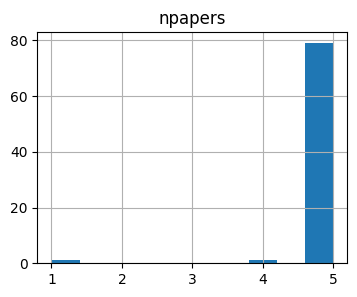

assignments_q_0.75_4_5.json


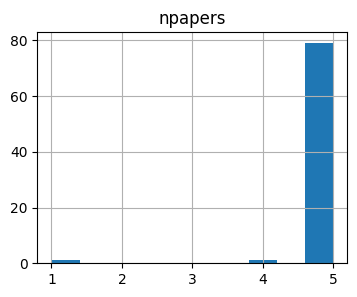

In [7]:
for matching_name, info in all_matchings.items():
    print(matching_name)
    matchings = info['matchings']
    load_df = to_load_df(matchings)
    load_df['npapers'] = load_df['paper_info'].apply(lambda x: len(x))
    load_df.hist(column='npapers', figsize=(4,3))
    info['load_df'] = load_df
    all_matchings[matching_name] = info
    plt.show()
    hr()

# Compare Changes in Matchings

Given two set of assigned reviewers (A, B) for a given `paper_id`, we can define
1. Set differences: $A-B$ and $B-A$
3. $\frac{A\cap B}{A\cup B}$

The some simple statistics can be computed to get a sense of how 'different' the two schemes are, such as;
1. % of papers where the matchings did not change; $A-B = B-A = 0$.
2. % of papers where the matchings completely changed $\frac{A\cap B}{A\cup B} = 0$.
3. For the papers where the matchings changed, how much did the corresponding mean-score change.
4. ?


In [8]:
import itertools

def unique_product(sets):
    result = set()
    for prod in itertools.product(sets, sets):
        result.add(tuple(sorted(prod)))
    return result

def compute_pairwise_stats(df_a, df_b):
    df_a = df_a.set_index('paper_id')
    df_b = df_b.set_index('paper_id')
    df_a.columns = [c + '_a' for c in df_a.columns]
    df_b.columns = [c + '_b' for c in df_b.columns]
    df_join = df_b.join(df_a)
    df_join['set_reviewers_b'] = df_join['reviewers_b'].apply(lambda x: set(x))
    df_join['set_reviewers_a'] = df_join['reviewers_a'].apply(lambda x: set(x))
    df_join['set_union_ab'] = df_join.apply(lambda x: x.set_reviewers_a.union(x.set_reviewers_b), axis=1)
    df_join['set_inter_ab'] = df_join.apply(lambda x: x.set_reviewers_a.intersection(x.set_reviewers_b), axis=1)
    df_join['len(a-b)'] = (df_join['set_reviewers_a'] - df_join['set_reviewers_b']).apply(lambda x: len(x))
    df_join['len(b-a)'] = (df_join['set_reviewers_b'] - df_join['set_reviewers_a']).apply(lambda x: len(x))
    df_join['inter/union'] = df_join.apply(lambda x: len(x.set_inter_ab) / len(x.set_union_ab), axis=1)
    df_join['mean_score_a-mean_score_b'] = df_join.apply(lambda x: x.mean_paper_score_a - x.mean_paper_score_b, axis=1)
    df_join['mean_score_b-mean_score_a'] = df_join.apply(lambda x: x.mean_paper_score_b - x.mean_paper_score_a, axis=1)
    return df_join[['len(a-b)', 'len(b-a)', 'inter/union', 'mean_score_b-mean_score_a', 'mean_score_a-mean_score_b']]
    
sources = list(all_matchings.keys())
source_pairs = unique_product(sources)

a = assignments_max_4_5.json vs b = assignments_q_0.75_4_5.json
Histogram of changes in assignments between A and B


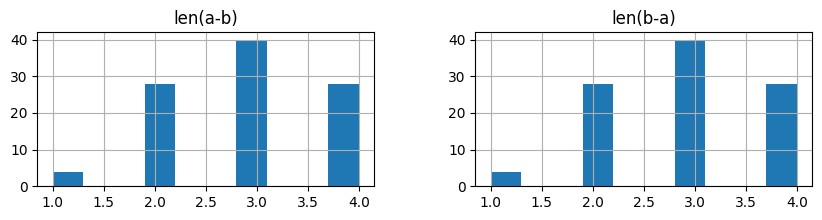

Boxplot of score change vs #chagnes in assignments


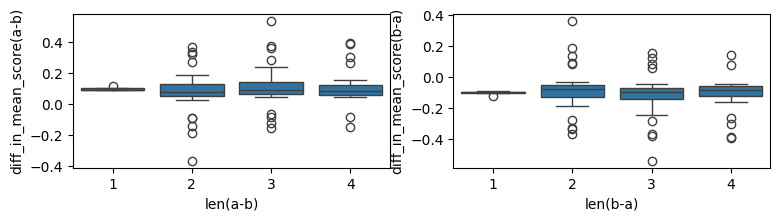

In [11]:
for (key_a, key_b) in source_pairs:
    # Debugging
    if key_a == key_b: continue
        
    df_a, df_b = all_matchings[key_a]['matchings_df'].copy(), all_matchings[key_b]['matchings_df'].copy()
    print("a =", key_a, "vs", "b =", key_b)
    stats = compute_pairwise_stats(df_a, df_b)
    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))
    # If sizes of a and b are same, then these are identical
    stats.hist(column='len(a-b)', ax=axs[0])
    stats.hist(column='len(b-a)', ax=axs[1])
    print("Histogram of changes in assignments between A and B")
    #stats.hist(column='inter/union', ax=axs[2])
    plt.show()
    print("Boxplot of score change vs #chagnes in assignments")
    fig, axs = plt.subplots(1, 2, figsize=(9,2))
    # Note: Positive change means assignment under A was better
    sns.boxplot(data=stats, x='len(a-b)', y='mean_score_a-mean_score_b', ax=axs[0])
    axs[0].set_ylabel("diff_in_mean_score(a-b)")
    sns.boxplot(data=stats, x='len(b-a)', y='mean_score_b-mean_score_a', ax=axs[1])
    axs[1].set_ylabel("diff_in_mean_score(b-a)")
    plt.show()
    hr()
  

1. Most of the assignments seem to change when going from A to B. There are very few cases with 0-change.
2. When going from `a=assignments_max_4_5.json` to `b=assignments_q_0.75_4_5.json` (lower right plot) the score differences seem to be slightly worse on average.